In [1]:
using JLD, Plots
using HDF5
using Base.Iterators
push!(LOAD_PATH,".")
include("ArbolGrafosTikz.jl")
using ArbolGrafosTikz

gr()

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/ArbolGrafosTikz.ji for ArbolGrafosTikz [top-level]
└ @ Base loading.jl:1190


ErrorException: importing ArbolGrafosTikz into Main conflicts with an existing identifier

In [2]:
arxname="../JLDFiles/Evocada/control1/LFP_Promedio_est_con5.jld"
datos=load(arxname)
csd=datos["kCSDCorrecta"]
freq=datos["freq"]
retr=datos["retrazo"]
lat=datos["latencia"]
cresp=datos["Canalesrespuesta"]
csatu=datos["CanalesSaturados"];

In [3]:
(h,w,nmax)=size(csd)
epsi=21
  ss=[-1,0,1]

3-element Array{Int64,1}:
 -1
  0
  1

In [4]:
size(csd)

(64, 64, 1163)

In [5]:
retr+lat+3*freq

170.56650615657293

In [6]:
maximum(csd[:,:,117:end])

581.7767582987807

In [7]:
keys(datos)

Base.KeySet for a Dict{String,Any} with 10 entries. Keys:
  "Canalesrespuesta"
  "KTT_KInv"
  "freq"
  "latencia"
  "kCSDCorrecta"
  "retrazo"
  "Nota"
  "LFPSaturados"
  "final"
  "CanalesSaturados"

In [8]:
function simboliza(x, delta=epsi)
    result=0
    if x>delta
        result=1
    elseif x< -delta
        result=-1
    else
        result=0
    end
    return result
end

simboliza (generic function with 2 methods)

In [9]:
csdsymb=map(x->simboliza(x), csd);

In [10]:
xs=csdsymb[16,28,:];
ys=[1]

1-element Array{Int64,1}:
 1

In [11]:
function problock(xxs::Array, yys::Array)
    # calculamos la prob exp de encontrar el array yys en el array xxs
    lx=length(xxs)
    ly=length(yys)
    lp=lx-ly+1
    result=0
    if(lx<ly)
        error("tuabueliuta")
    else
        for j=1:lp
            if xxs[j:j+ly-1]==yys
                result+=1
            end
        end
    end
    return result/lp
end

problock (generic function with 1 method)

In [12]:
function ncartprod(ss, n)
    argumento=ntuple(i->ss, n)
    result=product(argumento...)
    return(result)
end

ncartprod (generic function with 1 method)

In [13]:
# con permiso de StackOverflow oooo.key takes lot to compile!
issubvec(v,big) = any([v == big[i:(i+length(v)-1)] for i=1:(length(big)-length(v)+1)])

issubvec (generic function with 1 method)

In [14]:
function allprobsn(xxs, ss, n)
    result=Dict{Array, Float64}()
    palabras=ncartprod(ss, n)
    malas=Set()
    for p in palabras
        pr=[p...]
        aux=problock(xxs, pr)
        if aux>0
            result[pr]= aux
        else
            push!(malas, pr)
        end
    end
    return (result, malas)
end


function allprobsn(xxs, ss, n, vacias)
    
    #ush tambien muy ineficiente. Sigue siendo mejor buscar a lo pendejo???
            result=Dict{Array, Float64}()
    palabras=ncartprod(ss, n)
    malas=Set()
    for p in palabras
        pr=[p...]
        tanteada=any(issubvec(v, pr) for v in vacias)
        if tanteada
         #   print(pr, " esta tanteada!!  ")
            aux=0
        else
            aux=problock(xxs, pr)
            if aux>0
                result[pr]= aux
            else
                push!(malas, pr)
            end
        end # sobre tanteada
    end #sobre palabras
    return (result, malas)
end

allprobsn (generic function with 2 methods)

Haciendo pruebas, al parecer matar el conjunto de malas con entre 3 y 4 letras es la forma más rapida. Ya despues de eso tiene que revisar palabrerias tan largas que no conviene.

In [15]:
@time (p, v3)=allprobsn(xs, ss, 3)

  0.351561 seconds (855.07 k allocations: 44.928 MiB, 3.78% gc time)


(Dict{Array,Float64}([-1, -1, 0]=>0.000861326,[0, -1, -1]=>0.000861326,[0, 0, 0]=>0.953488,[0, -1, 0]=>0.00172265,[-1, 0, 0]=>0.00258398,[1, 0, 0]=>0.000861326,[0, 0, -1]=>0.00258398,[-1, -1, -1]=>0.0353144,[0, 0, 1]=>0.000861326,[0, 1, 0]=>0.000861326…), Set(Any[[1, -1, -1], [-1, 1, 1], [-1, 1, 0], [-1, 0, -1], [1, 0, -1], [1, 0, 1], [-1, -1, 1], [1, 1, 1], [1, -1, 0], [0, 1, -1], [-1, 0, 1], [1, -1, 1], [1, 1, -1], [1, 1, 0], [0, -1, 1], [-1, 1, -1], [0, 1, 1]]))

In [16]:
@time (p, v)=allprobsn(xs, ss, 9)

  2.029072 seconds (23.28 M allocations: 3.419 GiB, 26.02% gc time)


(Dict{Array,Float64}([0, 0, 0, 0, 0, 0, 0, 0, -1]=>0.0017316,[0, 0, 0, 0, 0, -1, 0, 0, 0]=>0.000865801,[0, 0, 0, 0, 0, 0, -1, 0, 0]=>0.000865801,[0, -1, 0, 0, 0, 0, 0, 0, 0]=>0.0017316,[-1, -1, 0, 0, 0, -1, 0, 0, 0]=>0.000865801,[0, 0, 0, 0, 0, 0, 0, 1, 0]=>0.000865801,[-1, -1, -1, -1, -1, -1, -1, -1, 0]=>0.000865801,[0, 0, -1, 0, 0, 0, 0, 0, 0]=>0.0017316,[0, 0, 0, 1, 0, 0, 0, 0, 0]=>0.000865801,[0, 0, 0, 0, 0, 0, 0, -1, -1]=>0.000865801…), Set(Any[[0, -1, -1, 1, 0, -1, 1, 0, -1], [-1, 0, 0, 0, -1, -1, -1, -1, 0], [1, 0, 1, 0, -1, -1, 0, -1, 1], [-1, -1, 0, 1, 1, 1, 1, 1, -1], [-1, 1, 0, 1, -1, -1, 1, 1, 0], [1, 0, -1, -1, -1, 1, 1, 0, 0], [-1, 1, 0, 1, -1, 0, 0, -1, -1], [1, 1, -1, 1, 0, 0, -1, 0, 0], [0, -1, 0, -1, 1, -1, 0, 0, 0], [0, 0, 1, -1, -1, 1, 0, -1, -1]  …  [0, 0, 0, 0, 0, 1, 0, 1, 1], [-1, 0, -1, 1, 1, 1, -1, 1, 1], [0, 0, 0, 0, 1, 1, 0, 0, 1], [1, 0, 0, 1, -1, -1, 1, -1, 0], [1, 0, 0, -1, 0, 0, 0, 0, 1], [1, 0, -1, -1, -1, -1, 0, 1, -1], [-1, -1, -1, 0, -1, 1, -1, 0, 1],

In [17]:
length(v3)

17

In [18]:
@time (ar, ir)=allprobsn(xs, ss,11, v3)

  1.032252 seconds (10.34 M allocations: 1.084 GiB, 18.36% gc time)


(Dict{Array,Float64}([0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1]=>0.000867303,[-1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0]=>0.000867303,[-1, -1, -1, 0, 0, 0, -1, 0, 0, 0, 0]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]=>0.000867303,[0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1]=>0.000867303,[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]=>0.028621,[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]=>0.000867303,[0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0]=>0.00173461…), Set(Any[[0, 0, 0, -1, -1, -1, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0], [-1, 0, 0, -1, 0, 0, 0, -1, 0, 0, 1], [0, -1, 0, 0, 0, 1, 0, 0, 0, -1, 0], [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1], [1, 0, 0, -1, 0, 0, 1, 0, 0, -1, -1], [0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0], [-1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, -1, 0, 0, -1, -1, 0, 0, -1, -1, -1]  …  [0, 1, 0, 0, 0, -1, -1, 0, 0, -1, -1], [-1, -1, -1, -1, 0, 0, -1, -1, -1, 0, 0], [0, 0, 0, -

In [19]:
function shanonH_n(xxs, ss, n)
    (probs, v)=allprobsn(xxs,ss,n)
    h=0
    for q in values(probs)
        if q>0.00001
            h+=q*log(q)
        end
    end
    result=-h/n
    return result
end

function shanonH_n(xxs, ss, n, v)
    (probs, v)=allprobsn(xxs,ss,n, v)
    h=0
    for q in values(probs)
        if q>0.00001
            h+=q*log(q)
        end
    end
    result=-h/n
    return result
end

function shanonH_n(probs,n)
    #meter un dict con probs>0 porfis
    h=0
    for q in values(probs)
        h+=q*log(q)
    end
    result=-h/n
    return result
end

shanonH_n (generic function with 3 methods)

In [20]:
lmax=length(cresp)

359

In [21]:
log(3, nmax)

6.425158561694472

In [22]:
hhsn=Dict{Array{Int, 1}, Array{Float64,1}}()
hhsn2=Dict{Array{Int, 1}, Array{Float64,1}}()
arbol=Dict{Array{Int,1}, Dict{Int, Array}}()
nn=7
@time for c in cresp
        reng=c[1]
        col=c[2]
        xs=csdsymb[reng,col,:]
        hhsn[c]=zeros(nn)
        arbol[c]=Dict{Int, Array}()
    for n=1:nn
            v=Set()
        if n<4
            probs, v= allprobsn(xs, ss,n)
        else
            probs, v2= allprobsn(xs, ss,n, v)
        end
            buenas=collect(keys(probs))
            arbol[[reng, col]][n]=buenas
        hhsn[[reng,col]][n]=shanonH_n(probs,n)
            
    end

    
end


121.402555 seconds (1.37 G allocations: 175.882 GiB, 33.29% gc time)


In [23]:
arbex=arbol[[26,39]]

Dict{Int64,Array} with 7 entries:
  7 => Array[[1, 1, 1, 1, 1, 1, -1], [1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0, …
  4 => Array[[1, 1, 1, -1], [-1, -1, -1, -1], [1, 1, 1, 1], [0, 0, -1, 0], [0, …
  2 => Array[[0, -1], [-1, 0], [-1, -1], [0, 0], [1, 0], [1, -1], [1, 1], [0, 1…
  3 => Array[[1, -1, -1], [0, -1, -1], [-1, -1, 0], [0, 0, 0], [1, 1, 1], [0, 1…
  5 => Array[[-1, 0, 0, 1, 1], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [-1, -1, 0, 0,…
  6 => Array[[0, 0, 0, 0, 0, 1], [0, -1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, -…
  1 => Array[[1], [-1], [0]]

In [28]:
ramerio=Subarbol[]
for n=1:4
    for a in arbex[n]
        nodito=Nodo(a)
        jijov=Nodo[]
        arbolillo=Subarbol(nodito,jijov)
        for b in arbex[n+1]
            if a==b[1:end-1] # si b pro
                ramita=Nodo(b)
                push!(arbolillo.hijos, ramita)
            end
        end
        push!(ramerio,arbolillo)
    end
end

arbolfull=Arbol(ramerio)

Arbol(Subarbol[Subarbol(Nodo([1]), Nodo[Nodo([1, 0]), Nodo([1, -1]), Nodo([1, 1])]), Subarbol(Nodo([-1]), Nodo[Nodo([-1, 0]), Nodo([-1, -1])]), Subarbol(Nodo([0]), Nodo[Nodo([0, -1]), Nodo([0, 0]), Nodo([0, 1])]), Subarbol(Nodo([0, -1]), Nodo[Nodo([0, -1, -1]), Nodo([0, -1, 0])]), Subarbol(Nodo([-1, 0]), Nodo[Nodo([-1, 0, 0])]), Subarbol(Nodo([-1, -1]), Nodo[Nodo([-1, -1, 0]), Nodo([-1, -1, -1])]), Subarbol(Nodo([0, 0]), Nodo[Nodo([0, 0, 0]), Nodo([0, 0, 1]), Nodo([0, 0, -1])]), Subarbol(Nodo([1, 0]), Nodo[Nodo([1, 0, 0])]), Subarbol(Nodo([1, -1]), Nodo[Nodo([1, -1, -1])]), Subarbol(Nodo([1, 1]), Nodo[Nodo([1, 1, 1]), Nodo([1, 1, -1])])  …  Subarbol(Nodo([0, 0, 0, 1]), Nodo[Nodo([0, 0, 0, 1, 0])]), Subarbol(Nodo([0, 0, 0, 0]), Nodo[Nodo([0, 0, 0, 0, 1]), Nodo([0, 0, 0, 0, -1]), Nodo([0, 0, 0, 0, 0])]), Subarbol(Nodo([0, 0, -1, -1]), Nodo[Nodo([0, 0, -1, -1, -1])]), Subarbol(Nodo([1, 0, 0, 0]), Nodo[Nodo([1, 0, 0, 0, 0])]), Subarbol(Nodo([0, 0, 1, 1]), Nodo[Nodo([0, 0, 1, 1, 1])]), Suba

In [29]:
grafodelArbol=walk_tree(arbolfull)

LabelledTree({73, 70} directed simple Int64 graph, Any[[1], [1, 0], [1, -1], [1, 1], [-1], [-1, 0], [-1, -1], [0], [0, -1], [0, 0]  …  [0, 0, 0, 0, 0], [0, 0, -1, -1, -1], [1, 0, 0, 0, 0], [0, 0, 1, 1, 1], [1, -1, -1, -1, -1], [-1, 0, 0, 0, 0], [0, -1, 0, 0, 0], [1, 1, -1, -1, -1], [-1, -1, 0, 0, 1], [-1, -1, 0, 0, 0]])

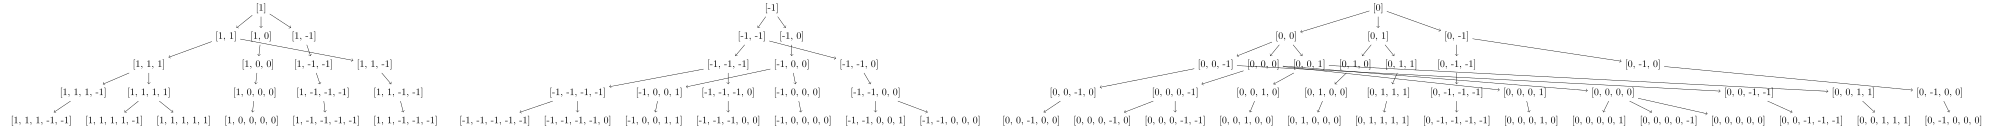

In [31]:
blabla=tikz_representation(grafodelArbol)

In [33]:
using TikzPictures # this is required for saving
TikzPictures.save(PDF("graph"), blabla)

In [ ]:
sum3n(n)=Int32(3/2*(-1+3^n))

In [ ]:
function trescodifica(xxs)
    #Convierte tus strings raros en un entero como si fuera ternario
    # con las cifras 0,1,2 (que son las que tienes +1)
    ll=length(xxs)
    r=0
    for j=1:ll
       a=xxs[j]+1
       r+=3^(ll-j)*a
    end
    return r
end

In [ ]:
function codanumero(xxs)
    ll=length(xxs)
    naux=sum3n(ll-1)
    bla=trescodifica(xxs)
    r=bla+naux+1 # la raiz en realidad es "ningun signo"
    return r
end

In [ ]:
bl=[-1,-1,0,1,0]

In [ ]:
codanumero(bl)

In [ ]:
trescodifica(bl)

In [ ]:
nredu

In [ ]:
arbex=arbol[[23,43]]
for a in arbol[[23,43]][2]
    print(a, " ")
end

In [ ]:
nredu=3
nodosmax=sum3n(nredu)
adja=zeros(Int8,nodosmax,nodosmax);
println(nodosmax)

In [ ]:
for n=1:nredu-1
    for a in arbex[n]
        acode=codanumero(a)
        for b in arbex[n+1]
            bcode=codanumero(b)
            if a==b[1:end-1] # si b proviene de a mas un sufijo 
                print("a=",a, " b=",b, " acode=", acode, " bcode=",bcode, ". \n")
                adja[acode,bcode]=1
            end
        end
    end
end



In [ ]:
etiquetas=Dict{Int64, String}()
for n=1:nredu
    for a in arbex[n]
        cod=codanumero(a)
        etiquetas[cod]=string(a)
    end
end


In [ ]:
etiquetas

In [ ]:
adja=adja+adja';

In [ ]:
pp=plot(key=false)
b=1:nn
for k in keys(hhsn)
    y=hhsn[k]
    scatter!(pp, b, y)
end

In [ ]:
pp

In [ ]:
xxx=[]
yyy=[]
gord1=[]
gord2=[]
for k in keys(hhsn)
    push!(xxx, k[2])
    push!(yyy, k[1])
    push!(gord1, hhsn[k][1])
    push!(gord2, hhsn[k][end])
end
    

In [ ]:
ppp=heatmap(csd[:,:,160], aspect_ratio=1, clims=(-20,20))
scatter!(xxx, yyy, markersize=gord1.*20, label="H_1", markeralpha=gord1)
scatter!(xxx, yyy, markersize=gord2.*20, label="H_8")


In [ ]:
retr+lat

In [ ]:
using LightGraphs, GraphPlot

In [ ]:
using TikzGraphs

In [ ]:
TikzGraphs.plot(arg)

In [ ]:
arg=Graph(A)

In [ ]:
TikzGraphs.plot(arg)

In [ ]:
rem_vertex!(arg, 5)

In [ ]:
TikzGraphs.plot(arg)

In [ ]:
arbol1=Graph(adja)

In [ ]:
palos=edges(arbol1)

In [ ]:
nodos=collect(vertices(arbol1));


In [ ]:
arbol1podado=Graph()

In [ ]:
for q in palos 
    print(q)
    add_edge!(arbol1podado,q)
end

In [ ]:
palos[1]

In [ ]:
TikzGraphs.plot(arbol1)

In [ ]:
max1=maximum(aar)
max8=maximum(bbr)

In [ ]:
for k in keys(hhsn)
    if hhsn[k][1]==min1
        print(k, " es el min de 1 bloque. ")
    elseif hhsn[k][1]==max1
        print(k, " es el max de 1 bloque. ")
    end
   if hhsn[k][8]==min8
        print(k, " es el min de 8 bloque. ")
    elseif hhsn[k][8]==max8
        print(k, " es el max de 8 bloque. ")
    end
end


In [ ]:
hhsn[:,:,1]==hhsn[:,:,4]

In [ ]:
allprobsn(xs, ss, 3)

In [ ]:
ss=[-1,0,1]
bla=[[q, j] for q in ss, j in ss ]

In [ ]:
struct ONodo
    mesmo
end
a=ONodo(1)

In [ ]:
?Nodo

In [ ]:
struct fobar
    fo
    bar
end

In [ ]:
a=fobar(1,2)

In [ ]:
problock(xs, [1]) , problock(xs, [0]),problock(xs, [-1])

In [ ]:
heatmap(sumsym, aspect_ratio=1)

In [ ]:
?heatmap

In [ ]:
a=[0,1]
n=[0, 1]
z=[1,1,0]
z2=[1,0,1]

In [ ]:
@time issubvec(a, z2)

In [ ]:
@inbounds

In [ ]:
as=string(a)